# Graph ML project

Football tactical pattern finding through zone clustering.


In [377]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from kloppy import wyscout, statsbomb
from kloppy.domain import Orientation
import kloppy
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

## Players


Let's load the metadata about players.


In [378]:
df_players = pd.read_csv("data/players.csv")
df_players.set_index("player_id", inplace=True)
df_players

,weight,first_name,middle_name,last_name,team_id,birth_date,height,foot,short_name,current_national_team_id,passport_area_name,passport_area_id,passport_area_alpha3code,passport_area_alpha2code,role_code2,role_code3,role_name,birth_area_name,birth_area_id,birth_area_alpha3code,birth_area_alpha2code
player_id,,,,,,,,,,,,,,,,,,,,,
32777,78,Harun,NaN,Tekin,4502.0,1989-06-17,187,right,H. Tekin,4687.0,Turkey,792,TUR,TR,GK,GKP,Goalkeeper,Turkey,792,TUR,TR
393228,73,Malang,NaN,Sarr,3775.0,1999-01-23,182,left,M. Sarr,4423.0,Senegal,686,SEN,SN,DF,DEF,Defender,France,250,FRA,FR
393230,72,Over,NaN,Mandanda,3772.0,1998-10-26,176,NaN,O. Mandanda,NaN,France,250,FRA,FR,GK,GKP,Goalkeeper,France,250,FRA,FR
32793,82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,right,A. N'Diaye,19314.0,Senegal,686,SEN,SN,MD,MID,Midfielder,France,250,FRA,FR
393247,84,Ibrahima,NaN,Konaté,2975.0,1999-05-25,192,right,I. Konaté,NaN,France,250,FRA,FR,DF,DEF,Defender,France,250,FRA,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120839,72,Ali,NaN,Maâloul,16041.0,1990-01-01,175,left,A. Maâloul,NaN,Tunisia,788,TUN,TN,DF,DEF,Defender,Tunisia,788,TUN,TN
114736,76,Carlos Alberto,NaN,Cáceda Oyaguez,15591.0,1991-09-27,183,right,C. Cáceda,NaN,Peru,604,PER,PE,GK,GKP,Goalkeeper,Peru,604,PER,PE
114908,78,Miguel Gianpierre,NaN,Araujo Blanco,12072.0,1994-10-24,179,right,M. Araujo,NaN,Peru,604,PER,PE,DF,DEF,Defender,Peru,604,PER,PE


In [379]:
# find role for player
player = df_players.loc[14943]
print(player["role_code2"])
print(player["role_code3"])
print(player["role_name"])

FW
FWD
Forward


In [380]:
df_players.loc[14812]

weight                              80
first_name                        Ivan
middle_name                        NaN
last_name                      Perišić
team_id                         3161.0
birth_date                  1989-02-02
height                             186
foot                             right
short_name                  I. Perišić
current_national_team_id        9598.0
passport_area_name             Croatia
passport_area_id                   191
passport_area_alpha3code           HRV
passport_area_alpha2code            HR
role_code2                          MD
role_code3                         MID
role_name                   Midfielder
birth_area_name                Croatia
birth_area_id                      191
birth_area_alpha3code              HRV
birth_area_alpha2code               HR
Name: 14812, dtype: object

In [381]:
ROLE_TYPES = sorted(df_players["role_code2"].unique().tolist())
ROLE_TYPES

['DF', 'FW', 'GK', 'MD']

## Events


In [382]:
class ZoneTransformer:
    """Transform pitch coordinates into predefined zones."""

    def __init__(self):
        """Initialize the ZoneTransformer with predefined segments and boundaries."""

        self.INCLUDE_COLS = [
            "event_id",
            "event_type",
            "period_id",
            "timestamp",
            "team_id",
            "player_id",
            "coordinates_*",
            "end_coordinates_*",
            "is_counter_attack",
            "pass_type",
            "result",
            "success",
            "duel_type",
            "set_piece_type",
            "body_part_type",
            "goalkeeper_type",
            "card_type",
        ]

        # self.cols = ["*"]

        self.DROP_COLS = [
            "coordinates_x",
            "coordinates_y",
            "end_coordinates_x",
            "end_coordinates_y",
        ]
        self.width_segments = [6, 10, 17, 17, 17, 17, 10, 6]
        self.height_segments = [19, 18, 26, 18, 19]

        self.n_rows = len(self.height_segments)
        self.n_cols = len(self.width_segments)
        self.n_zones = self.n_rows * self.n_cols  # 8 x 5
        self.outside_zone_id = self.n_zones

        # precompute cumulative boundaries
        self.width_boundaries = np.cumsum([0] + self.width_segments)
        self.height_boundaries = np.cumsum([0] + self.height_segments)

        self.zone_names = self._create_zone_names()

    def _create_zone_names(self) -> dict:
        """Create a mapping from zone IDs to human-readable names."""

        row_names = [
            "RIGHT_WING",
            "RIGHT_HALF",
            "CENTER",
            "LEFT_HALF",
            "LEFT_WING",
        ]

        col_names = [
            "DEF_BOX",  # Defensive 6-yard area
            "DEF_PENALTY",  # Defensive penalty area
            "DEF_THIRD_DEEP",  # Deep defensive third
            "DEF_THIRD",  # Defensive third
            "MID_THIRD_DEF",  # Middle third (defensive half)
            "MID_THIRD_ATT",  # Middle third (attacking half)
            "ATT_THIRD",  # Attacking third
            "ATT_PENALTY",  # Attacking penalty area
        ]

        zone_names = {}
        for col in range(self.n_cols):
            for row in range(self.n_rows):
                zone_id = self.rowcol_to_id(row, col)
                zone_names[zone_id] = f"{row_names[row]}_{col_names[col]}"

        zone_names[self.outside_zone_id] = "OUTSIDE"

        return zone_names

    def coords_to_zone(self, x: float, y: float):
        """Convert (x, y) coordinates to a zone ID and (row, col) tuple.

        Args:
            x (float): x-coordinate (0 to 100)
            y (float): y-coordinate (0 to 100)
        Returns:
            tuple: (zone_id, (row, col))
        """
        if not x or not y or x < 0 or x > 100 or y < 0 or y > 100:
            return self.outside_zone_id, (-1, -1)

        # exactly at boundary (100, 100)
        if x == 100 and y == 100:
            return self.outside_zone_id, (-1, -1)

        # find column
        col = np.searchsorted(self.width_boundaries[1:], x, side="right")
        col = min(col, self.n_cols - 1)

        # find row
        row = np.searchsorted(self.height_boundaries[1:], y, side="right")
        row = min(row, self.n_rows - 1)

        zone_id = self.rowcol_to_id(row, col)
        return zone_id, (row, col)

    def rowcol_to_id(self, row: int, col: int) -> int:
        """Convert (row, col) to zone ID."""
        if row < 0 or row >= self.n_rows or col < 0 or col >= self.n_cols:
            return self.outside_zone_id
        return col * self.n_rows + (self.n_rows - row - 1)

    def id_to_rowcol(self, zone_id: int):
        """Convert zone ID to (row, col)."""
        if zone_id == self.outside_zone_id:
            return (-1, -1)

        row = self.n_rows - (zone_id % self.n_rows) - 1
        col = zone_id // self.n_rows
        return (row, col)

    def get_zone_bounds(self, zone_id: int):
        """Get the (x_min, x_max, y_min, y_max) boundaries of a zone given its ID."""
        if zone_id == self.outside_zone_id:
            return (100.0, 100.0, 100.0, 100.0)

        row, col = self.id_to_rowcol(zone_id)

        x_min = self.width_boundaries[col]
        x_max = self.width_boundaries[col + 1]
        y_min = self.height_boundaries[row]
        y_max = self.height_boundaries[row + 1]

        return (x_min, x_max, y_min, y_max)

    def get_zone_center(self, zone_id: int):
        """Get the (x_center, y_center) of a zone given its ID."""
        if zone_id == self.outside_zone_id:
            return (100.0, 100.0)

        x_min, x_max, y_min, y_max = self.get_zone_bounds(zone_id)
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        return (x_center, y_center)

    def get_zone_name(self, zone_id: int) -> str:
        """Get the human-readable name of a zone given its ID."""
        return self.zone_names.get(zone_id, f"ZONE_{zone_id}")

    def transform_row(self, event):
        start_x = event["coordinates_x"]
        start_y = event["coordinates_y"]

        start_zone_id, start_zone_name = None, None
        if not pd.isna(start_x) and not pd.isna(start_y):
            start_x *= 100
            start_y *= 100
            start_zone_id, _ = self.coords_to_zone(start_x, start_y)
            start_zone_name = self.get_zone_name(start_zone_id)

        end_x = event["end_coordinates_x"]
        end_y = event["end_coordinates_y"]

        end_zone_id, end_zone_name = None, None
        if not pd.isna(end_x) and not pd.isna(end_y):
            end_x *= 100
            end_y *= 100
            end_zone_id, _ = self.coords_to_zone(end_x, end_y)
            end_zone_name = self.get_zone_name(end_zone_id)

        return pd.Series(
            {
                "start_x": start_x,
                "start_y": start_y,
                "start_zone_id": start_zone_id,
                "start_zone_name": start_zone_name,
                "end_x": end_x,
                "end_y": end_y,
                "end_zone_id": end_zone_id,
                "end_zone_name": end_zone_name,
            }
        )

    def transform(self, df):
        """Transform coordinates in the dataframe to zones."""

        zone_data = df.apply(self.transform_row, axis=1)
        df = pd.concat([df, zone_data], axis=1)
        df["start_zone_id"] = df["start_zone_id"].astype(pd.Int64Dtype())
        df["end_zone_id"] = df["end_zone_id"].astype(pd.Int64Dtype())
        df["player_id"] = df["player_id"].astype(pd.Int64Dtype())
        df["team_id"] = df["team_id"].astype(pd.Int64Dtype())

        df = df.drop(columns=self.DROP_COLS, errors="ignore")

        return df


zt = ZoneTransformer()

We can use [kloppy](https://kloppy.pysport.org/) to load a match (and its events) using the [Wyscout](https://kloppy.pysport.org/user-guide/loading-data/wyscout/) dataset.


In [383]:
match_id = 2058017  # France vs Croatia World Cup Final 2018

data = wyscout.load_open_data(match_id)
data = data.transform(
    Orientation.ACTION_EXECUTING_TEAM
)  # the team that executes the action always plays from left to right (with x=100 being the opponent's goal)

home_team, away_team = data.metadata.teams
home_team_id, away_team_id = int(home_team.team_id), int(away_team.team_id)
print(f"Home team: {home_team.name} ({home_team_id})")
print(f"Away team: {away_team.name} ({away_team_id})")

df_raw = data.to_df(*zt.INCLUDE_COLS, engine="pandas")
df_raw.set_index("event_id", inplace=True)
df_raw = zt.transform(df_raw)
df_raw

Home team: France (4418)
Away team: Croatia (9598)


,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263883958,PASS,1,0 days 00:00:01.892339,9598,14943,False,SIMPLE_PASS,None,None,None,None,None,None,None,50.000000,50.897059,22,CENTER_MID_THIRD_DEF,NaN,NaN,<NA>,None
263883959,PASS,1,0 days 00:00:03.889375,9598,69968,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,39.247896,51.794118,17,CENTER_DEF_THIRD,34.530723,73.356209,16,LEFT_HALF_DEF_THIRD
263883960,PASS,1,0 days 00:00:06.140946,9598,8287,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,34.530723,73.356209,16,LEFT_HALF_DEF_THIRD,30.756984,92.501548,10,LEFT_WING_DEF_THIRD_DEEP
263883963,PASS,1,0 days 00:00:09.226570,9598,69409,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,30.756984,92.501548,10,LEFT_WING_DEF_THIRD_DEEP,11.349206,65.267974,6,LEFT_HALF_DEF_PENALTY
263883964,PASS,1,0 days 00:00:12.658969,9598,135747,False,LAUNCH,COMPLETE,True,None,None,None,None,None,11.349206,65.267974,6,LEFT_HALF_DEF_PENALTY,63.582408,50.897059,22,CENTER_MID_THIRD_DEF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263885652,PASS,2,0 days 00:49:38.301867,9598,3476,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,46.056884,21.251634,18,RIGHT_HALF_DEF_THIRD,63.582408,6.427245,24,RIGHT_WING_MID_THIRD_DEF
263885653,RECOVERY,2,0 days 00:49:39.084611,9598,14812,False,None,None,None,None,None,None,None,None,63.582408,6.427245,24,RIGHT_WING_MID_THIRD_DEF,NaN,NaN,<NA>,None
263885654,PASS,2,0 days 00:49:43.448628,9598,14812,False,HIGH_PASS,INCOMPLETE,False,None,None,LEFT_FOOT,None,None,80.564231,2.142415,29,RIGHT_WING_MID_THIRD_ATT,100.000000,100.000000,40,OUTSIDE


In [384]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1510 entries, 263883958 to 263885618
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   event_type         1510 non-null   object         
 1   period_id          1510 non-null   int64          
 2   timestamp          1510 non-null   timedelta64[ns]
 3   team_id            1510 non-null   Int64          
 4   player_id          1510 non-null   Int64          
 5   is_counter_attack  1502 non-null   object         
 6   pass_type          817 non-null    object         
 7   result             1321 non-null   object         
 8   success            1321 non-null   object         
 9   duel_type          385 non-null    object         
 10  set_piece_type     93 non-null     object         
 11  body_part_type     117 non-null    object         
 12  goalkeeper_type    19 non-null     object         
 13  card_type          6 non-null      objec

In [385]:
home_team_players = []
for player in home_team.players:
    position = df_players.loc[int(player.player_id)]["role_code2"]
    description = f"{position}:{str(player).encode().decode('unicode-escape')}"
    home_team_players.append(description)

len(home_team_players), home_team_players

(23,
 ["MD:N'Golo Kanté",
  'MD:Blaise Matuidi',
  'FW:Olivier Giroud',
  'DF:Raphaël Varane',
  'MD:Paul Pogba',
  'FW:Kylian Mbappé Lottin',
  'DF:Benjamin Pavard',
  'DF:Samuel Yves Umtiti',
  'DF:Lucas  Hernández Pi',
  'FW:Antoine Griezmann',
  'GK:Hugo Lloris',
  'GK:Alphonse Aréola',
  'DF:Djibril Sidibé',
  'GK:Steve Mandanda',
  'DF:Adil Rami',
  'MD:Thomas Lemar',
  'FW:Florian Thauvin',
  'FW:Ousmane Dembélé',
  'DF:Presnel Kimpembe',
  'DF:Benjamin Mendy',
  'MD:Corentin Tolisso',
  "MD:Steven N'Kemboanza Mike Christopher N'Zonzi",
  'MD:Nabil Fekir'])

We can also find all available values directly from the kloppy types:


In [386]:
EVENT_TYPES = sorted([t.value for t in kloppy.domain.EventType])
PASS_TYPES = sorted([t.value for t in kloppy.domain.PassType])
PASS_RESULTS = sorted([t.value for t in kloppy.domain.PassResult])
DUEL_TYPES = sorted([t.value for t in kloppy.domain.DuelType])
DUEL_RESULTS = sorted([t.value for t in kloppy.domain.DuelResult])
SHOT_RESULTS = sorted([t.value for t in kloppy.domain.ShotResult])
GOALKEEPER_TYPES = sorted([t.value for t in kloppy.domain.GoalkeeperActionType])
CARD_TYPES = sorted([t.value for t in kloppy.domain.CardType])
print(f"EVENT TYPES        {EVENT_TYPES}")
print(f"PASS TYPES         {PASS_TYPES}")
print(f"PASS RESULTS       {PASS_RESULTS}")
print(f"DUEL TYPES         {DUEL_TYPES}")
print(f"DUEL RESULTS       {DUEL_RESULTS}")
print(f"SHOT RESULTS       {SHOT_RESULTS}")
print(f"GOALKEEPER TYPES   {GOALKEEPER_TYPES}")
print(f"CARD TYPES         {CARD_TYPES}")

EVENT TYPES        ['BALL_OUT', 'CARD', 'CARRY', 'CLEARANCE', 'DUEL', 'FORMATION_CHANGE', 'FOUL_COMMITTED', 'GOALKEEPER', 'INTERCEPTION', 'MISCONTROL', 'PASS', 'PLAYER_OFF', 'PLAYER_ON', 'PRESSURE', 'RECOVERY', 'SHOT', 'SUBSTITUTION', 'TAKE_ON', 'generic']
PASS TYPES         ['ASSIST', 'ASSIST_2ND', 'CHIPPED_PASS', 'CROSS', 'FLICK_ON', 'HAND_PASS', 'HEAD_PASS', 'HIGH_PASS', 'LAUNCH', 'LONG_BALL', 'SHOT_ASSIST', 'SIMPLE_PASS', 'SMART_PASS', 'SWITCH_OF_PLAY', 'THROUGH_BALL']
PASS RESULTS       ['COMPLETE', 'INCOMPLETE', 'OFFSIDE', 'OUT']
DUEL TYPES         ['AERIAL', 'GROUND', 'LOOSE_BALL', 'SLIDING_TACKLE', 'TACKLE']
DUEL RESULTS       ['LOST', 'NEUTRAL', 'WON']
SHOT RESULTS       ['BLOCKED', 'GOAL', 'OFF_TARGET', 'OWN_GOAL', 'POST', 'SAVED']
GOALKEEPER TYPES   ['CLAIM', 'PICK_UP', 'PUNCH', 'REFLEX', 'SAVE', 'SAVE_ATTEMPT', 'SMOTHER']
CARD TYPES         ['FIRST_YELLOW', 'RED', 'SECOND_YELLOW']


And in the data:


In [387]:
event_types = sorted(df_raw["event_type"].dropna().unique())
pass_types = sorted(df_raw["pass_type"].dropna().unique())
pass_results = sorted(df_raw["result"].dropna().unique())
duel_types = sorted(
    df_raw[df_raw["event_type"] == "DUEL"]["duel_type"].dropna().unique()
)
duel_results = sorted(
    df_raw[df_raw["event_type"] == "DUEL"]["result"].dropna().unique()
)
shot_results = sorted(
    df_raw[df_raw["event_type"] == "SHOT"]["result"].dropna().unique()
)
goalkeeper_types = sorted(
    df_raw[df_raw["event_type"] == "GOALKEEPER"]["goalkeeper_type"].dropna().unique()
)
card_types = sorted(
    df_raw[df_raw["event_type"] == "CARD"]["card_type"].dropna().unique()
)
print(f"event types        {event_types}")
print(f"pass types         {pass_types}")
print(f"pass results       {pass_results}")
print(f"duel types         {duel_types}")
print(f"duel results       {duel_results}")
print(f"shot results       {shot_results}")
print(f"goalkeeper types   {goalkeeper_types}")
print(f"card types         {card_types}")

event types        ['CARD', 'CLEARANCE', 'DUEL', 'FOUL_COMMITTED', 'GENERIC:generic', 'GOALKEEPER', 'INTERCEPTION', 'MISCONTROL', 'PASS', 'RECOVERY', 'SHOT']
pass types         ['ASSIST', 'CROSS', 'HAND_PASS', 'HEAD_PASS', 'HIGH_PASS', 'LAUNCH', 'SIMPLE_PASS', 'SMART_PASS', 'THROUGH_BALL']
pass results       ['BLOCKED', 'COMPLETE', 'GOAL', 'INCOMPLETE', 'LOST', 'NEUTRAL', 'OFFSIDE', 'OFF_TARGET', 'SAVED', 'SUCCESS', 'WON']
duel types         ['AERIAL', 'GROUND', 'SLIDING_TACKLE']
duel results       ['LOST', 'NEUTRAL', 'WON']
shot results       ['BLOCKED', 'GOAL', 'OFF_TARGET', 'SAVED']
goalkeeper types   ['REFLEX', 'SAVE', 'SAVE_ATTEMPT']
card types         ['FIRST_YELLOW']


We prune the data to only keep passes, shots, duels and goalkeeper action events.

In [388]:
INCLUDE_EVENTS = ["PASS", "SHOT", "DUEL", "GOALKEEPER"]

df = df_raw[df_raw["event_type"].isin(INCLUDE_EVENTS)]
df

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263883958,PASS,1,0 days 00:00:01.892339,9598,14943,False,SIMPLE_PASS,None,None,None,None,None,None,None,50.000000,50.897059,22,CENTER_MID_THIRD_DEF,NaN,NaN,<NA>,None
263883959,PASS,1,0 days 00:00:03.889375,9598,69968,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,39.247896,51.794118,17,CENTER_DEF_THIRD,34.530723,73.356209,16,LEFT_HALF_DEF_THIRD
263883960,PASS,1,0 days 00:00:06.140946,9598,8287,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,34.530723,73.356209,16,LEFT_HALF_DEF_THIRD,30.756984,92.501548,10,LEFT_WING_DEF_THIRD_DEEP
263883963,PASS,1,0 days 00:00:09.226570,9598,69409,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,30.756984,92.501548,10,LEFT_WING_DEF_THIRD_DEEP,11.349206,65.267974,6,LEFT_HALF_DEF_PENALTY
263883964,PASS,1,0 days 00:00:12.658969,9598,135747,False,LAUNCH,COMPLETE,True,None,None,None,None,None,11.349206,65.267974,6,LEFT_HALF_DEF_PENALTY,63.582408,50.897059,22,CENTER_MID_THIRD_DEF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263885650,PASS,2,0 days 00:49:24.715715,9598,69396,False,HIGH_PASS,INCOMPLETE,False,None,None,None,None,None,35.474157,23.049020,18,RIGHT_HALF_DEF_THIRD,73.016754,23.947712,28,RIGHT_HALF_MID_THIRD_ATT
263885651,PASS,2,0 days 00:49:32.985039,9598,69968,False,HAND_PASS,COMPLETE,True,None,THROW_IN,None,None,None,35.474157,0.000000,40,OUTSIDE,46.056884,21.251634,18,RIGHT_HALF_DEF_THIRD
263885652,PASS,2,0 days 00:49:38.301867,9598,3476,False,SIMPLE_PASS,COMPLETE,True,None,None,None,None,None,46.056884,21.251634,18,RIGHT_HALF_DEF_THIRD,63.582408,6.427245,24,RIGHT_WING_MID_THIRD_DEF


In [389]:
unique_players = df["player_id"].nunique()
print(f"Total unique players: {unique_players}")

Total unique players: 27


In [390]:
df_home = df[df["team_id"] == home_team_id]
df_away = df[df["team_id"] == away_team_id]

In [391]:
df_home[df_home["event_type"] == "SHOT"].head(2)

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263884513,SHOT,1,0 days 00:37:58.895744,4418,3682,False,None,GOAL,True,None,PENALTY,LEFT_FOOT,REFLEX,None,88.650794,49.102941,32,CENTER_ATT_THIRD,100.0,45.514706,37,CENTER_ATT_PENALTY
263884759,SHOT,2,0 days 00:01:10.341174,4418,3682,False,None,SAVED,False,None,None,LEFT_FOOT,SAVE_ATTEMPT,None,74.903623,61.159664,27,CENTER_MID_THIRD_ATT,100.0,50.000000,37,CENTER_ATT_PENALTY


In [392]:
df_home[df_home["start_zone_id"] == 37].head(
    2
)  # first two events from attacking penalty area center (zone 37)

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263885723,DUEL,2,0 days 00:15:45.012465,4418,353833,False,None,LOST,False,AERIAL,None,None,None,None,94.761905,50.897059,37,CENTER_ATT_PENALTY,NaN,NaN,<NA>,None


In [393]:
transitions_from_center_att_third = df_home[
    df_home["start_zone_id"] == 22
]  # get first 2 transitions starting from center attacking third (zone 22)

transitions_from_center_att_third[
    [
        "event_type",
        "start_zone_id",
        "start_zone_name",
        "end_zone_id",
        "end_zone_name",
    ]
].head(2)

,event_type,start_zone_id,start_zone_name,end_zone_id,end_zone_name
event_id,,,,,
263884177,DUEL,22,CENTER_MID_THIRD_DEF,<NA>,None
263884179,PASS,22,CENTER_MID_THIRD_DEF,23,RIGHT_HALF_MID_THIRD_DEF


In [394]:
df_home[(df_home["event_type"] == "SHOT") & (df_home["period_id"] == 1)].head(
    1
)  # get first shot in first half

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263884513,SHOT,1,0 days 00:37:58.895744,4418,3682,False,None,GOAL,True,None,PENALTY,LEFT_FOOT,REFLEX,None,88.650794,49.102941,32,CENTER_ATT_THIRD,100.0,45.514706,37,CENTER_ATT_PENALTY


In [395]:
df_home[(df_home["event_type"] == "SHOT") & (df_home["period_id"] == 2)].head(
    1
)  # get first shot in second half

,event_type,period_id,timestamp,team_id,player_id,is_counter_attack,pass_type,result,success,duel_type,set_piece_type,body_part_type,goalkeeper_type,card_type,start_x,start_y,start_zone_id,start_zone_name,end_x,end_y,end_zone_id,end_zone_name
event_id,,,,,,,,,,,,,,,,,,,,,,
263884759,SHOT,2,0 days 00:01:10.341174,4418,3682,False,None,SAVED,False,None,None,LEFT_FOOT,SAVE_ATTEMPT,None,74.903623,61.159664,27,CENTER_MID_THIRD_ATT,100.0,50.0,37,CENTER_ATT_PENALTY


In [396]:
next_zones = transitions_from_center_att_third["end_zone_id"].value_counts().head(5)
print(f"\nTop 5 destination zones from center attacking third:")
for zone_id, count in next_zones.items():
    zone_name = zt.get_zone_name(zone_id)
    print(f"Zone {zone_id} ({zone_name}): {count} times")


Top 5 destination zones from center attacking third:
Zone 24 (RIGHT_WING_MID_THIRD_DEF): 2 times
Zone 23 (RIGHT_HALF_MID_THIRD_DEF): 1 times
Zone 7 (CENTER_DEF_PENALTY): 1 times
Zone 12 (CENTER_DEF_THIRD_DEEP): 1 times
Zone 22 (CENTER_MID_THIRD_DEF): 1 times


In [397]:
df_home_22 = df_home[df_home["start_zone_id"] == 22]
print(f"Events: {df_home_22['event_type'].value_counts()}", "\n")
print(f"Players: {df_home_22['player_id'].nunique()}", "\n")
print(f"End zones: {df_home_22['end_zone_id'].value_counts()}")

Events: event_type
DUEL    11
PASS    10
Name: count, dtype: int64 

Players: 7 

End zones: end_zone_id
24    2
23    1
7     1
12    1
22    1
21    1
27    1
38    1
25    1
Name: count, dtype: Int64


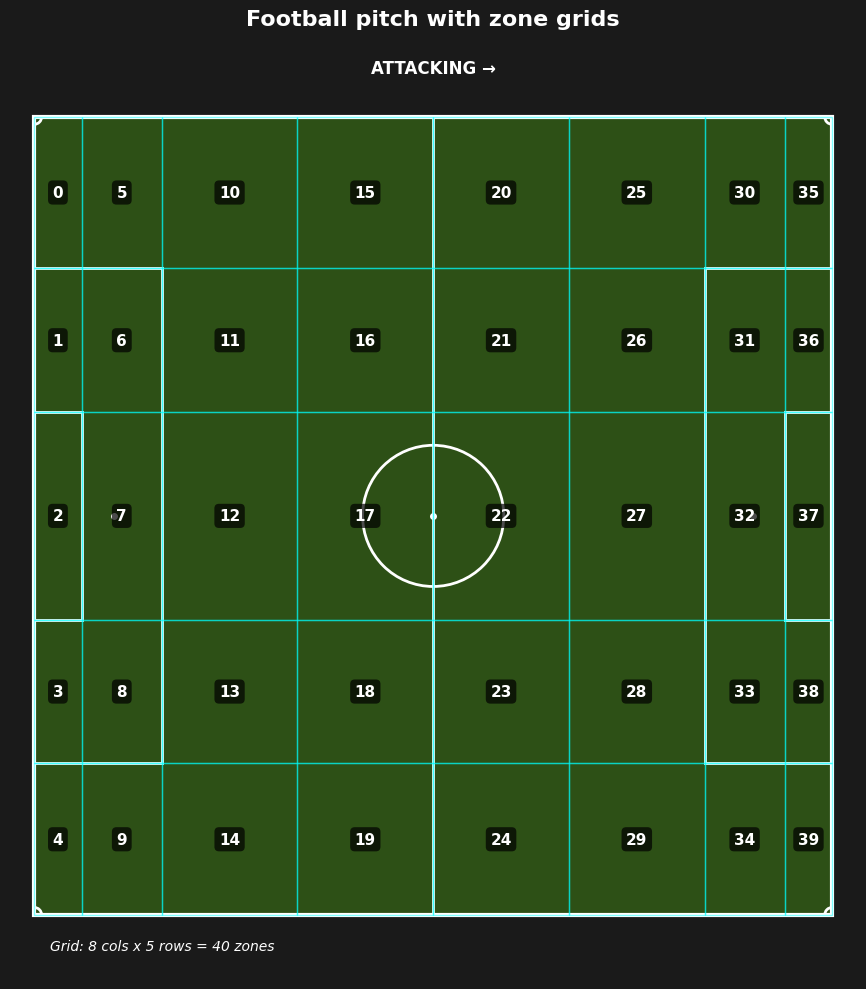

In [398]:
def plot_pitch_zones(zt, figsize=(14, 10), highlight_zones=None):
    """
    Plot football pitch with zone grid and IDs

    Args:
        discretizer: FootballFieldDiscretizer instance
        figsize: Figure size (width, height)
        highlight_zones: List of zone IDs to highlight (optional)
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor="#1a1a1a")
    ax.set_facecolor("#2d5016")

    pitch_length = 100
    pitch_width = 100

    # pitch outline
    pitch_rect = patches.Rectangle(
        (0, 0),
        pitch_length,
        pitch_width,
        linewidth=3,
        edgecolor="white",
        facecolor="#2d5016",
        zorder=1,
    )
    ax.add_patch(pitch_rect)

    # halfway line
    ax.plot([50, 50], [0, 100], color="white", linewidth=2, zorder=2)

    # center circle
    center_circle = patches.Circle(
        (50, 50),
        kloppy.domain.WyscoutPitchDimensions.circle_radius,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(center_circle)
    ax.plot(50, 50, "o", color="white", markersize=4, zorder=2)

    # penalty areas
    penalty_width = 62
    penalty_depth = 16
    penalty_margin = (100 - penalty_width) / 2

    left_penalty = patches.Rectangle(
        (0, penalty_margin),
        penalty_depth,
        penalty_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(left_penalty)

    right_penalty = patches.Rectangle(
        (100 - penalty_depth, penalty_margin),
        penalty_depth,
        penalty_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(right_penalty)

    # goal areas
    goal_width = kloppy.domain.WyscoutPitchDimensions.six_yard_width
    goal_depth = kloppy.domain.WyscoutPitchDimensions.six_yard_length
    goal_margin = (100 - goal_width) / 2

    left_goal = patches.Rectangle(
        (0, goal_margin),
        goal_depth,
        goal_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(left_goal)

    right_goal = patches.Rectangle(
        (100 - goal_depth, goal_margin),
        goal_depth,
        goal_width,
        linewidth=2,
        edgecolor="white",
        facecolor="none",
        zorder=2,
    )
    ax.add_patch(right_goal)

    # penalty spots
    penalty_spot_distance = kloppy.domain.WyscoutPitchDimensions.penalty_spot_distance
    ax.plot(penalty_spot_distance, 50, "o", color="white", markersize=4, zorder=2)
    ax.plot(100 - penalty_spot_distance, 50, "o", color="white", markersize=4, zorder=2)

    # corner arcs
    corner_radius = kloppy.domain.WyscoutPitchDimensions.corner_radius
    for x, y in [(0, 0), (0, 100), (100, 0), (100, 100)]:
        if x == 0 and y == 0:
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=0,
                theta2=90,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        elif x == 0 and y == 100:
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=270,
                theta2=360,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        elif x == 100 and y == 0:
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=90,
                theta2=180,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        else:  # (100, 100)
            arc = patches.Arc(
                (x, y),
                corner_radius * 2,
                corner_radius * 2,
                angle=0,
                theta1=180,
                theta2=270,
                linewidth=2,
                edgecolor="white",
                zorder=2,
            )
        ax.add_patch(arc)

    for row in range(zt.n_rows):
        for col in range(zt.n_cols):
            zone_id = zt.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = zt.get_zone_bounds(zone_id)

            if highlight_zones and zone_id in highlight_zones:
                facecolor = "yellow"
                alpha = 0.3
                edgecolor = "yellow"
                linewidth = 2
            else:
                facecolor = "none"
                alpha = 0.5
                edgecolor = "cyan"
                linewidth = 1

            zone_rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=linewidth,
                edgecolor=edgecolor,
                facecolor=facecolor,
                alpha=alpha,
                zorder=3,
            )
            ax.add_patch(zone_rect)

            x_center, y_center = zt.get_zone_center(zone_id)

            bbox_props = dict(
                boxstyle="round,pad=0.3", facecolor="black", alpha=0.7, edgecolor="none"
            )

            ax.text(
                x_center,
                y_center,
                str(zone_id),
                ha="center",
                va="center",
                fontsize=11,
                fontweight="bold",
                color="white",
                bbox=bbox_props,
                zorder=4,
            )

    # ax.text(
    #     50,
    #     -5,
    #     "← DEFENSIVE",
    #     ha="center",
    #     va="top",
    #     fontsize=12,
    #     color="white",
    #     fontweight="bold",
    # )
    ax.text(
        50,
        105,
        "ATTACKING →",
        ha="center",
        va="bottom",
        fontsize=12,
        color="white",
        fontweight="bold",
    )

    info_text = f"Grid: {zt.n_cols} cols x {zt.n_rows} rows = {zt.n_zones} zones"
    ax.text(
        2,
        -3,
        info_text,
        ha="left",
        va="top",
        fontsize=10,
        color="white",
        style="italic",
    )

    ax.set_xlim(-3, 103)
    ax.set_ylim(-8, 108)
    ax.set_aspect("equal")
    ax.axis("off")

    plt.title(
        "Football pitch with zone grids",
        fontsize=16,
        color="white",
        fontweight="bold",
        pad=20,
    )
    plt.tight_layout()

    return fig, ax


def plot_zone_grid_simple(zt, figsize=(14, 10)):
    """
    Simplified grid visualization - just zones and IDs, no pitch markings
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")

    # Draw each zone
    for row in range(zt.n_rows):
        for col in range(zt.n_cols):
            zone_id = zt.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = zt.get_zone_bounds(zone_id)

            # alternating colours
            if (row + col) % 2 == 0:
                facecolor = "#e8f4e8"
            else:
                facecolor = "#d4e8d4"

            # Draw zone
            zone_rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="black",
                facecolor=facecolor,
                zorder=1,
            )
            ax.add_patch(zone_rect)

            x_center, y_center = zt.get_zone_center(zone_id)
            zone_name = zt.get_zone_name(zone_id)

            # zone id
            ax.text(
                x_center,
                y_center + 2,
                str(zone_id),
                ha="center",
                va="center",
                fontsize=16,
                fontweight="bold",
                color="black",
            )

            # zone name
            ax.text(
                x_center,
                y_center - 2,
                zone_name.replace("_", "\n"),
                ha="center",
                va="center",
                fontsize=6,
                color="#555",
                style="italic",
            )

    for row in range(zt.n_rows):
        y_center = (zt.height_boundaries[row] + zt.height_boundaries[row + 1]) / 2
        ax.text(
            -2,
            y_center,
            f"Row {row}",
            ha="right",
            va="center",
            fontsize=10,
            fontweight="bold",
        )

    for col in range(zt.n_cols):
        x_center = (zt.width_boundaries[col] + zt.width_boundaries[col + 1]) / 2
        ax.text(
            x_center,
            102,
            f"Col {col}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_xlim(-5, 105)
    ax.set_ylim(-2, 105)
    ax.set_aspect("equal")
    ax.axis("off")

    plt.title("Zone grids", fontsize=14, fontweight="bold", pad=10)
    plt.tight_layout()

    return fig, ax


def plot_zone_heatmap(
    discretizer, zone_counts, figsize=(14, 10), title="Zone activity"
):
    """
    Heatmap visualization of zone activity

    Args:
        discretizer: FootballFieldDiscretizer instance
        zone_counts: dict or Series with {zone_id: count}
        figsize: Figure size
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=figsize)

    if hasattr(zone_counts, "to_dict"):
        zone_counts = zone_counts.to_dict()

    max_count = max(zone_counts.values()) if zone_counts else 1

    for row in range(discretizer.n_rows):
        for col in range(discretizer.n_cols):
            zone_id = discretizer.rowcol_to_id(row, col)
            x_min, x_max, y_min, y_max = discretizer.get_zone_bounds(zone_id)

            count = zone_counts.get(zone_id, 0)
            intensity = count / max_count if max_count > 0 else 0

            # white (no activity) -> red (high activity)
            color = plt.cm.Reds(intensity * 0.8 + 0.2)

            # Draw zone
            zone_rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=1,
                edgecolor="gray",
                facecolor=color,
                zorder=1,
            )
            ax.add_patch(zone_rect)

            # labels
            x_center, y_center = discretizer.get_zone_center(zone_id)

            # zone id
            ax.text(
                x_center,
                y_center + 1.5,
                str(zone_id),
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

            # count
            ax.text(
                x_center,
                y_center - 1.5,
                str(count),
                ha="center",
                va="center",
                fontsize=9,
                color="black",
            )

    # add colour bar
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=max_count)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Event Count", rotation=270, labelpad=15)

    ax.set_xlim(-2, 102)
    ax.set_ylim(-2, 102)
    ax.set_aspect("equal")
    ax.axis("off")

    plt.title(title, fontsize=14, fontweight="bold", pad=10)
    plt.tight_layout()

    return fig, ax


plot_pitch_zones(zt)
plt.show()

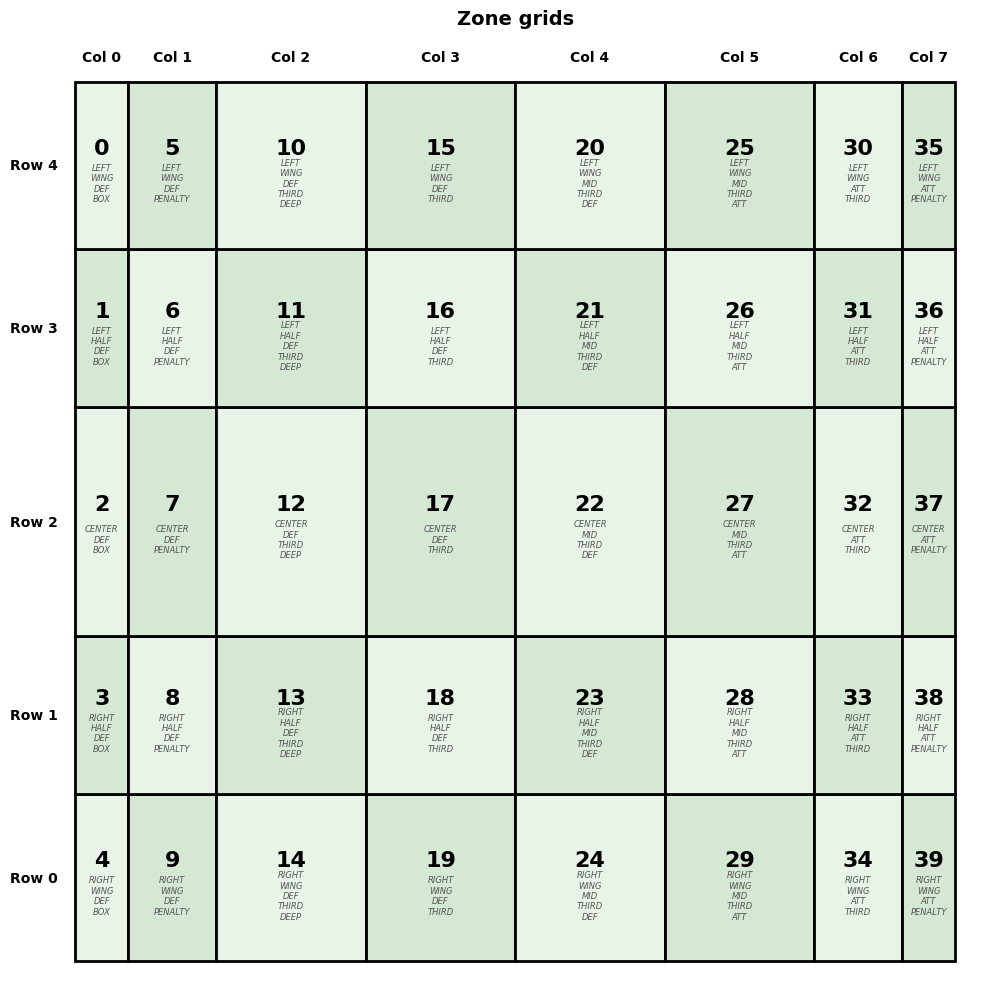

In [399]:
plot_zone_grid_simple(zt)
plt.show()

(<Figure size 1400x1000 with 2 Axes>,
 <Axes: title={'center': 'Zone activity'}>)

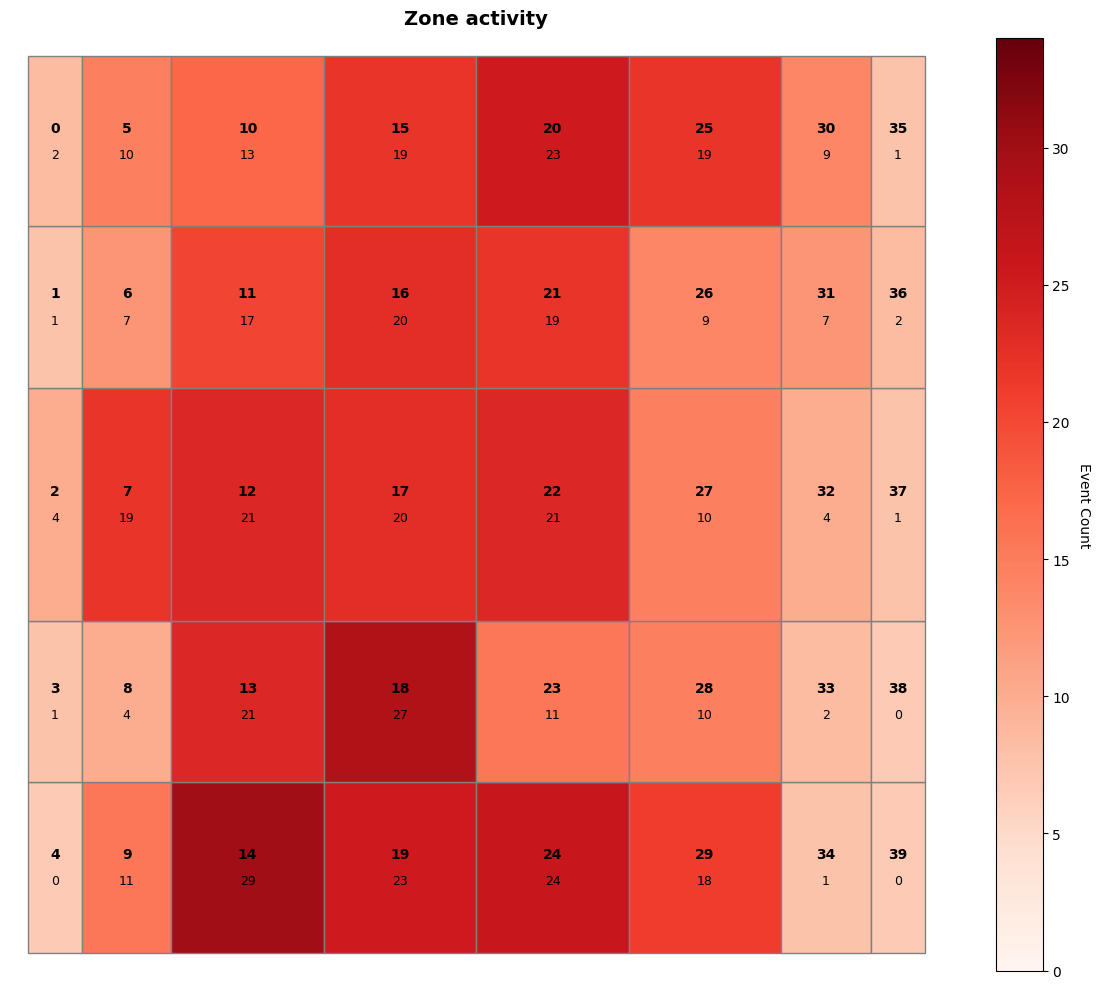

In [400]:
plot_zone_heatmap(zt, df_home["start_zone_id"].value_counts())

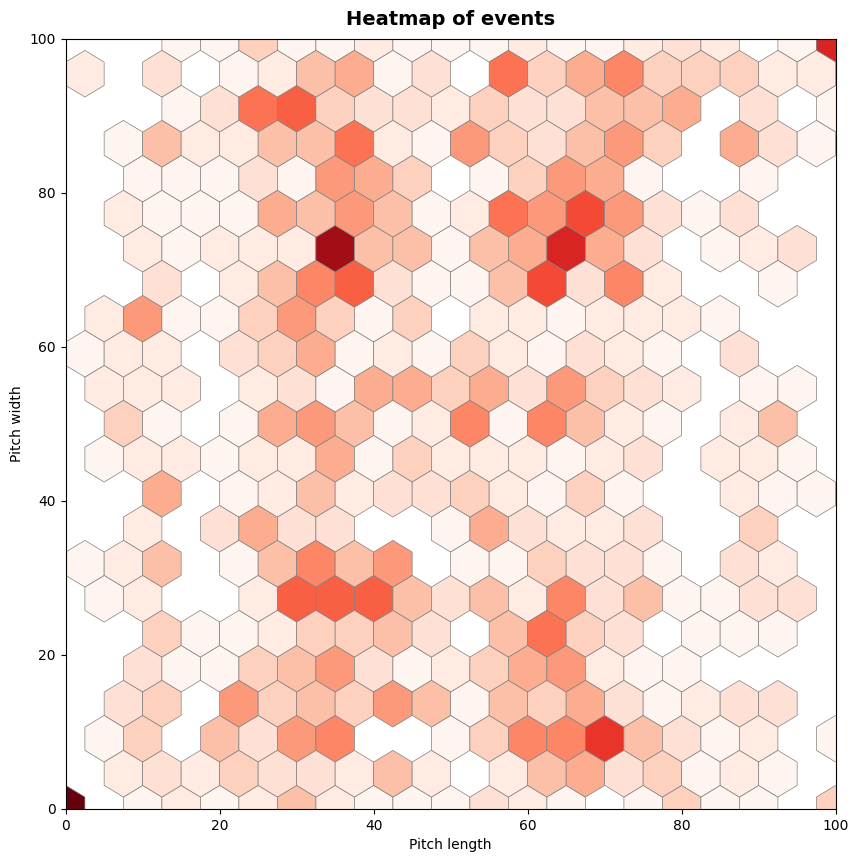

In [401]:
# heatmap of all events without zones
coordinates = df[["start_x", "start_y"]].dropna()

plt.figure(figsize=(14, 10))
plt.hexbin(
    coordinates["start_x"],
    coordinates["start_y"],
    gridsize=20,
    cmap="Reds",
    mincnt=1,
    edgecolors="gray",
    linewidths=0.5,
)
# plt.colorbar(label="Event count")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.gca().set_aspect("equal")
plt.title("Heatmap of events", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("Pitch length")
plt.ylabel("Pitch width")
plt.grid(False)
plt.show()

## Graph

We create a graph $G = (V, E)$ and let a node be a zone $z \in V$ and the edge be the transition from a starting zone $z_{start}$ to an end zone $z_{end}$ where $e = (z_{start}, z_{end}) \in E$ with the edge weight $w(e)$ being the frequency - the number of transitions.

Node attributes:

- `event_count`, the number of events starting from $z$.
- `most_common_event`, the most common event type in $z$.
- `unique_players`, the number of unique players in $z$.
- `role_distribution`, the zone's role distribution: we one-hot encode the role distributions in each zone. 

Specifically, an event may originate from a goalkeeper `GK`, defender `DF`, midfielder `MD` or Forward `FW`. We encode these in a distributions as $[p_{\tiny\text{GK}}, p_{\tiny\text{DF}}, p_{\tiny\text{MD}}, p_{\tiny\text{FW}}]$ where $p_r$ is the proportion of events originating from a player with role $r$ in the zone.

Edge attributes:

- `weight`, the number of transitions from $z_{start}$ to $z_{end}$.
- `transition_frequency`, the number of transitions from $z_{start}$ to $z_{end}$ divided by total number of events starting from $z_{start}$. In short, it gives the likelihood of moving from $z_{start}$ to $z_{end}$.
- `most_common_event`, the most common event type from $z_{start}$ to $z_{end}$.


In [411]:
def get_role_distributions(zone_events: pd.DataFrame):
    role_counts = df_players[df_players.index.isin(zone_events["player_id"])][
        "role_code2"
    ].value_counts()
    role_distributions = [
        role_counts.get("GK", 0),
        role_counts.get("DF", 0),
        role_counts.get("MD", 0),
        role_counts.get("FW", 0),
    ]
    return (
        np.array(role_distributions) / np.sum(role_distributions)
        if np.sum(role_distributions) > 0
        else np.array([0, 0, 0, 0])
    )


# example distribution for zone 22
zone_events = df_home[df_home["start_zone_id"] == 22]
get_role_distributions(zone_events)

array([0.        , 0.14285714, 0.57142857, 0.28571429])

In [412]:
def build_transition_graph(df):
    """
    Build a directed graph of zone transitions from event data

    Args:
        df: DataFrame with 'start_zone_id' and 'end_zone_id' columns
    Returns:
        DiGraph with zones as nodes and transitions as weighted edges
    """
    G = nx.DiGraph()
    transitions = df.dropna(subset=["start_zone_id", "end_zone_id"])
    for _, row in transitions.iterrows():
        start_zone = row["start_zone_id"]
        end_zone = row["end_zone_id"]
        if G.has_edge(start_zone, end_zone):
            G[start_zone][end_zone]["weight"] += 1
        else:
            G.add_edge(start_zone, end_zone, weight=1)

    # add edge attributes
    for u, v in G.edges():
        zone_events = df[(df["start_zone_id"] == u) & (df["end_zone_id"] == v)]
        G[u][v]["transition_frequency"] = G[u][v]["weight"] / G.out_degree(
            u, weight="weight"
        )
        G[u][v]["most_common_event"] = (
            zone_events["event_type"].value_counts().idxmax()
        )  # most common event type
        G[u][v]["start_zone_name"] = zt.get_zone_name(u)
        G[u][v]["end_zone_name"] = zt.get_zone_name(v)

    # add node attributes
    for zone_id in G.nodes():
        zone_events = df[df["start_zone_id"] == zone_id]
        G.nodes[zone_id]["event_count"] = len(zone_events)  # number of events
        G.nodes[zone_id]["most_common_event"] = (
            zone_events["event_type"].value_counts().idxmax()
            if not zone_events.empty
            else None
        )  # most common event type
        G.nodes[zone_id]["unique_players"] = zone_events[
            "player_id"
        ].nunique()  # unique players
        G.nodes[zone_id]["zone_name"] = zt.get_zone_name(zone_id)  # human-readable name
        G.nodes[zone_id]["role_distribution"] = get_role_distributions(
            zone_events
        )  # role distribution [GK, DF, MD, FW]
    return G


def visualise_transition_graph(G):
    """
    Visualise the zone transition graph.

    Args:
        G: DiGraph with zones as nodes and transitions as weighted edges
    """

    pos = {zone_id: zt.get_zone_center(zone_id) for zone_id in G.nodes()}
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    plt.figure(figsize=(7, 5))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=500,
        node_color="lightblue",
        arrowsize=20,
        edge_color=weights,
        edge_cmap=plt.cm.Blues,
        width=2,
    )
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weights), vmax=max(weights))
    )
    sm.set_array([])
    # cbar = plt.colorbar(sm, ax=plt.gca(), label="Transition frequency")
    plt.title("Zone transition graph", fontsize=14, fontweight="bold", pad=10)
    plt.show()

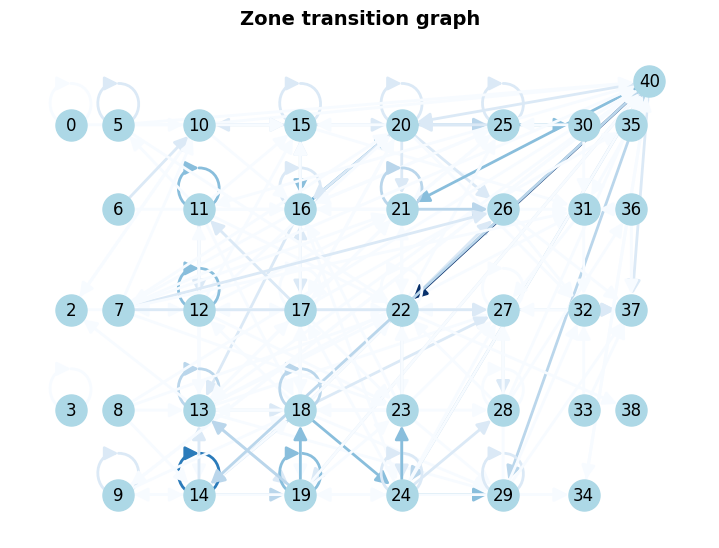

In [413]:
G_home = build_transition_graph(df_home)
visualise_transition_graph(G_home)

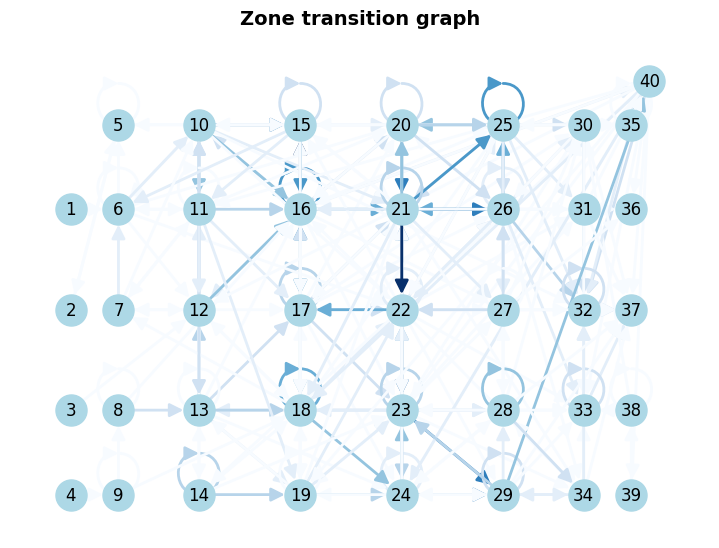

In [414]:
G_away = build_transition_graph(df_away)
visualise_transition_graph(G_away)